In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
import sys
sys.path.append("../figures")

from robust_what_BCEloss import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST

In [5]:
from main import init
args = init(filename='../data/2019-06-12')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-05',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'what_offset_std': 5.0,
 'what_offset_max': 15}

## Unit tests

In [7]:
transform=transforms.Compose([
                               WhatShift(args, i_offset=None, j_offset=None),
                               WhatBackground(),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

In [8]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

In [9]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [10]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

In [11]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [12]:
data, label = next(iter(test_loader))

In [13]:
label.shape

torch.Size([100])

Text(0.5, 1.0, 'label : 2')

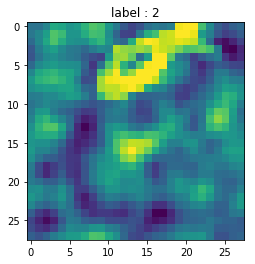

In [14]:
i = 3
plt.imshow(data[i,:,:].detach().numpy().reshape((28, 28)))
plt.title('label : '+str(label[i].item()))

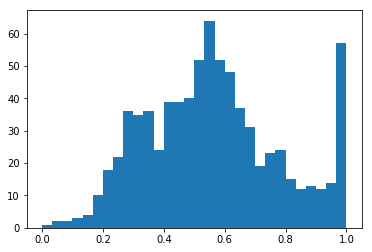

In [15]:
h = plt.hist(data[1,:,:].detach().numpy().flatten(), 30)

In [16]:
device = 'cpu'
model = WhatNet(args).to(device)
loss_func = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr = 1e-3)